# Meta-analysis of COVID-19 papers

### Project for Management and Analysis of Physics Datasets (Mod. B)
***

By: LamBHrusco gang

Benassi Federica (2019102), Ghidoni Rebecca (2026709), Negri Luca (2027589), Rinaldi Luca (2026363)



The COVID-19 pandemic has seen an unprecedented increase in the number of papers published on a single topic. The mass of information that is now readily accessible has been giving a hard time to the scientists, doctors and researchers trying to navigate it and finding what is useful.

That is why many Natural Language Processing (NLP) scientists have been trying to synthesize the mass of papers and distill the useful information from them. This project uses distributed processing frameworks to analyze the [massive dataset of papers regarding the COVID-19 pandemic](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). This dataset contains about ~200 000 thousands papers, we will work on just around 1000 due to our hardware limitation, but this code can be expanded to any cluster dimension.

## 0.1 Cluster setup

Since half of the group is not in Padua, we worked with three virtual machines from CloudVeneto resources. All the VMs have four threads and 8 GB of memory. One of the machines has the role of both scheduler and worker, and the other two are connected as workers.

In [14]:
import pandas as pd
import numpy  as np 
import time
import dask
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster

import dask.bag as db
import json
from urllib.request import urlopen

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import geopandas
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from nltk.corpus import stopwords
import io

import gensim
from gensim.models import KeyedVectors
import time

In [3]:
#cluster = LocalCluster(n_workers=4,threads_per_worker=2) 
#client  = Client(cluster)
client = Client('tcp://10.67.22.15:8786')
client

/usr/lib/python3.6/site-packages/distributed/client.py:1134: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+----------------------+
| Package | client | scheduler | workers              |
+---------+--------+-----------+----------------------+
| numpy   | 1.19.5 | 1.19.5    | {'1.19.5', '1.15.4'} |
+---------+--------+-----------+----------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://10.67.22.15:8786 Dashboard: http://10.67.22.15:12222/status,Cluster Workers: 3 Cores: 6 Memory: 15.20 GB


## 0.2 Read of papers from JSON files

The files containing the papers are in the format `.json`, thus we used the library `json` provided by python which converts them into dictionaries. The file are being read from github so we can give every worker the same path to files. The papers have been modified so that the whole file is in just one line.

In [4]:

#! rm dummy.mapd
#! ls COVID_papers >> dummy.mapd 

with open('dummy.mapd') as file: # file containing the name of the papers
    flist = ['json1line_COVID_papers/'+i.strip() for i in file] # string containing paths
with open('dummy.mapd') as file: 
    #string containing link to the github repository containing the papers.
    flistgit = ['https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/json1line_COVID_papers/'+i.strip() for i in file]

b = db.read_text(flistgit).map(json.loads).repartition(8) 
b

dask.bag<repartition, npartitions=8>

## 1.0) Word counter distributed algorithm.


In NLP the frequency of appearence of a word in the data is a very important quantity, so we want to compute it in the whole dataset of papers we are studing.

To complete this task we adopted a **Map-Reduce** approach to get these quantities, where a first count of how many times each of the words appear in each of the papers is performed (**Map** phase) and then the number of appearancies of the words between the documents is summed altogether (**Reduce** phase).

After the `body_text` field is plucked from the list of files, the **map** phase is handled by the function `word_counter` that accomplishes 3 main tasks:

* Concatenate the `text` field for each of the sections of the papers json

* Clean the resulting string, by deleting unwanted characters,numbers, and removing *stopwords* (common words in the whole english language not really interesting to process)

* Counting the occurencies of each word in the text






In [31]:
def word_counter(body_text_list):

    '''Function to concatenate the strings of text from the json, clean them from unwanted characters and     '''
    
    #print('Concatenate!' + paper_dict['paper_id'])
    
    #body_text_list  = paper_dict['body_text'] #read of the text
    
    #concatenation of every section into one text file
    total_text = ''
    for text_section in body_text_list:
        total_text += text_section['text']
        
    total_text = total_text.lower()#lowercase everything
        
    # deteleting all unwanted characters
    
    
    forbidden_chars = ".,()[]:*><;°%/+-=1234567890"
    
    for forbidden_ch in forbidden_chars:
        
        total_text = total_text.replace(forbidden_ch,"")
    
    total_text = total_text.replace('"','')
        
        
    #nofwords_counter
        
    text_list = total_text.split() # transform into a list
    
    stopw = stopwords.words('english') 
    otherw = stopw + ['fig', 'et', 'al', 'also', 'may', 'using', 'use', 'used', 'one', 'two', 'however', 'can', 'could'] + [str(i) for i in range(11)] 
    text_list = [i for i in text_list if i not in otherw]
    
    
    
    words, counts = np.unique(text_list, return_counts  = True) # count the words
    
    word_counts = [(key , count) for key,count in zip(words, counts)]

    return word_counts

    
    
    

In [32]:
def reduce_counts(word_list1,word_list2):
    
    """Combines the results od two dictionaries"""
    
    #obtaining the keys
    word_list_out = word_list1

    try:
        keys1 = list(word_list1.keys())
        keys2 = list(word_list2.keys())


        #add one value to the other
        for key2 in keys2:
                #check if already present
                if key2 not in keys1:
                    word_list_out[key2] = word_list2[key2]
                else:
                    word_list_out[key2] += word_list2[key2]
    except:
        pass
        
    return word_list_out
        
    

For the **reduce** phase we used the *foldby* functionality of dask bags, where a certain operation is applied to elements of the bag that share a certain key.

 The bags need to be flattened in order to have the elements of the bag being the signle tuple of word + number of occurency in paper. The operation applied is the sum of the occurencies.

 The result of this operation is a list of bags containing word + occurency in the whole corpus of papers. Below is possible to find the code to run the proces described above.

In [33]:
def add(x1,x2):
    return list(x1.items())[0][1] + list(x2.items())[0][1]

def add2(x1,x2):
    return x1 + x2[1]

def add3(a,b):
    return a+b

def binop(t, x):

    return max((t, x), key=lambda x: x[1])

In [34]:
#b_conc  = b.map(word_dellamadonna).flatten().foldby(lambda x:x[0],binop=add2)
b_conc = b.pluck('body_text').map(word_counter).flatten().foldby(lambda x:x[0],binop=add2,initial=0,combine=add3,combine_initial=(0,0))
word_count = b_conc.compute()

In [8]:
word_count = {key[0]:key[1][0] for key in word_count}

In [9]:
word_sort = dict(sorted(word_count.items(), key=lambda item: item[1])[::-1])

words_related_to_research = ['et','al','fig','data','study','number','model','results'
                             ,'figure','p','t','reported','public','table','studies','higher'
                            ,'different','population','shown','period','analysis','information']

words_related_to_COVID    = ['mers-cov','covid-19','patients','infection',
                             'rate','health','cases','virus','disease','human','pandemic',
                            'viral','autophagy','growth','response','nodules','lockdown',
                            'contact','cells','care','case','positive','protein','stem','epidemic'
                            ,'transimission','dna']

Below the most common words in the dataset can be seen, without the stopwords. The color indicates if the word is related to the pandemic or the research activity in general.

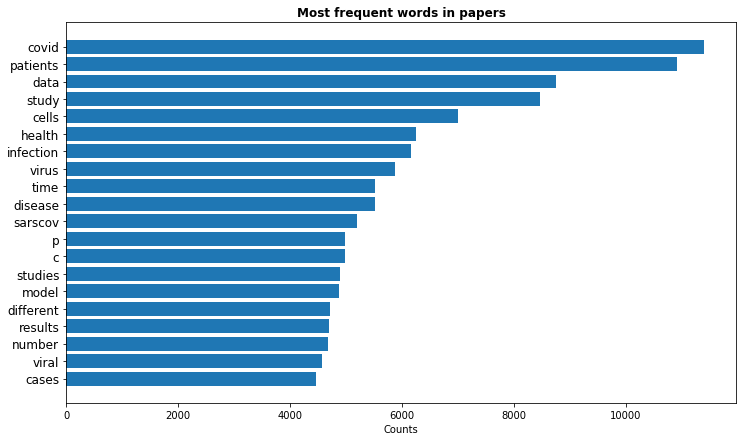

In [10]:
n_to_plot = 20
n_low = 0

list_of_vals = list(word_sort.values())[n_low:n_to_plot]
list_of_keys = list(word_sort.keys())[n_low:n_to_plot]

clist = []

for key in list_of_keys:
    
    if key in words_related_to_COVID:
        clist.append('orange')
    elif key in words_related_to_research:
        clist.append('green')
    else:
        clist.append('blue')
    

plt.subplots(figsize=[12,7])
my_cmap = plt.get_cmap("inferno")
plt.title('Most frequent words in papers', fontweight='bold')
plt.xlabel('Counts')
#plt.barh(list_of_keys[::-1],list_of_vals[::-1],color=clist[::-1])
plt.barh(list_of_keys[::-1],list_of_vals[::-1])#, color=clist[::-1])
#plt.xticks(rotation=60)
plt.yticks(fontsize=12)
plt.show()

The most common words are now presented in a wordcloud format in order to see them in a more intuitive way.

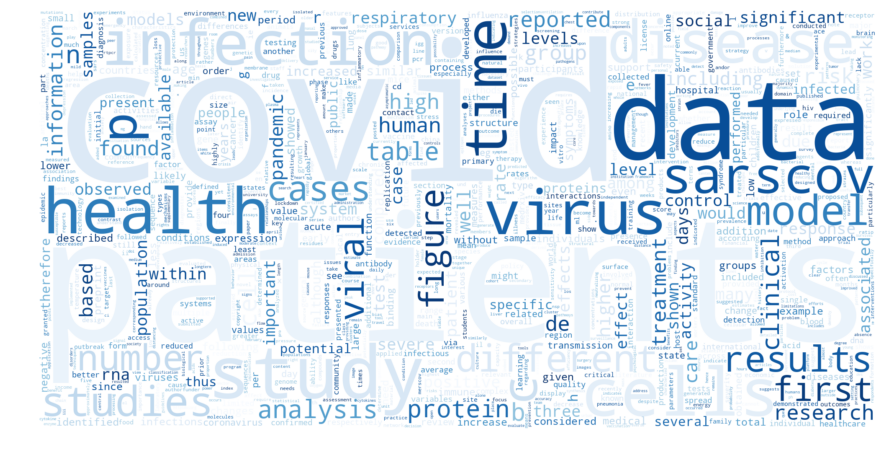

In [11]:
w_cloud = WordCloud(width=2000,height=1000,background_color='white',colormap='Blues',max_words=1000,prefer_horizontal=0.7).generate_from_frequencies(word_count)

plt.figure(figsize=[15,30])
plt.imshow(w_cloud, interpolation= 'bilinear')
plt.axis('off')
#plt.savefig('Word_Cloud.png',dpi=100)
plt.show()

## 1.2 ) Test with different workers and partitions.

We changed the number of workers and partitions to see how the code is affected. The partitions chosen are always a multiple of the number of workers so that the partitions are split evenly among them. we chose $1,4,8,32,64,128$ as the number of partitions and $1,2,4$ as the number of workers. Each worker has 2 threads.

The results are shown in a seaborn heatmap.

In [28]:
client.close()
#cluster.close()

In [ ]:
partitions = [1,4,8,32,64,128]
workers = [1,2,4]
times_array=np.zeros([len(workers),len(partitions)])

for i in range(len(workers)):
    for j in range(len(partitions)):
        
        cluster = LocalCluster(n_workers= workers[i],threads_per_worker=2)
        client = Client(cluster)
        
        b = db.read_text(flist).map(json.loads).repartition(partitions[j])
        time1 = time.time()
        
        word_count = b.pluck('body_text').map(word_dellamadonna2).flatten().foldby(lambda x:x[0],binop=add2,initial=0,combine=add3,combine_initial=(0,0)).compute()
        
        times_array[i,j] = time.time() - time1
        
        client.close()
        cluster.close()

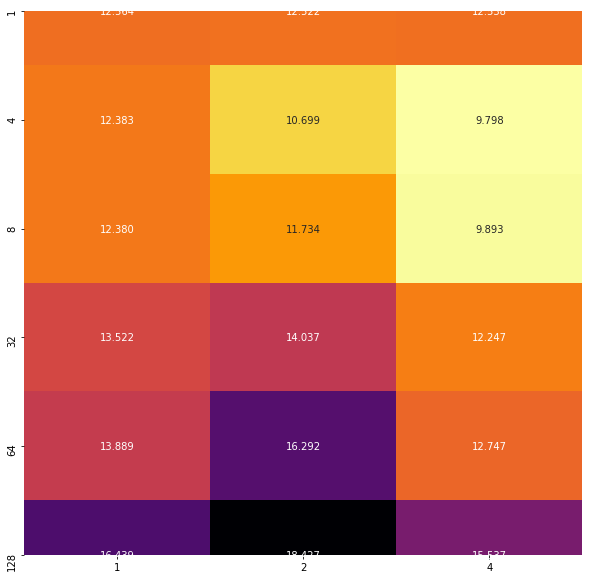

In [ ]:
import seaborn as sns

df_times=pd.DataFrame(times_array.T,partitions,workers)


fig,ax=plt.subplots(figsize=[10,10])


sns.heatmap(df_times,cmap='inferno_r',square=False,annot=True,fmt='.3f',cbar=False,ax=ax)
#plt.ylabel('workers')
#plt.xlabel('partitions')
plt.show()

As we can see, increasing the number of workers usually makes the process run faster. If the number of partitions is too high, the process becomes rather slow because of the time needed to merge all of the results. The best result has been obtained with 4 workers (8 threads) and 4 partitions: we can conclude that in this special case the optimal situation is reached when the number of partitions is the same or a small multiple of the number of workers or threads. 

## 1.2BUT ON CLUSTER) Test with different workers and partitions.

We changed the number of workers and partitions to see how the code is affected. The partitions chosen are always a multiple of the number of workers so that the partitions are split evenly among them. we chose $1,4,8,32,64,128$ as the number of partitions and $1,2,4$ as the number of workers. Each worker has 2 threads.

The results are shown in a seaborn heatmap.

In [35]:
partitions = [1,4,8,32,64,128]
workers = [1,2,4]
## ----------------------------------------------------------------------------------------
##   so the worker should be initialized to have as resources "ix" respectively: 4,3,2,2,1,1
## ----------------------------------------------------------------------------------------
times_array=np.zeros([len(workers),len(partitions)])

#b = db.read_text(flistgit).map(json.loads).repartition(partitions[j])

for i in range(len(workers)):
    for j in range(len(partitions)):
        
        with dask.annotate(resources={'ix': len(workers)-i}):
            b = db.read_text(flistgit).map(json.loads).repartition(partitions[j])
            time1 = time.time()
            word_count = b.pluck('body_text').map(word_counter).flatten().foldby(lambda x:x[0],binop=add2,initial=0,combine=add3,combine_initial=(0,0)).compute()
            times_array[i,j] = time.time() - time1

KeyboardInterrupt: 

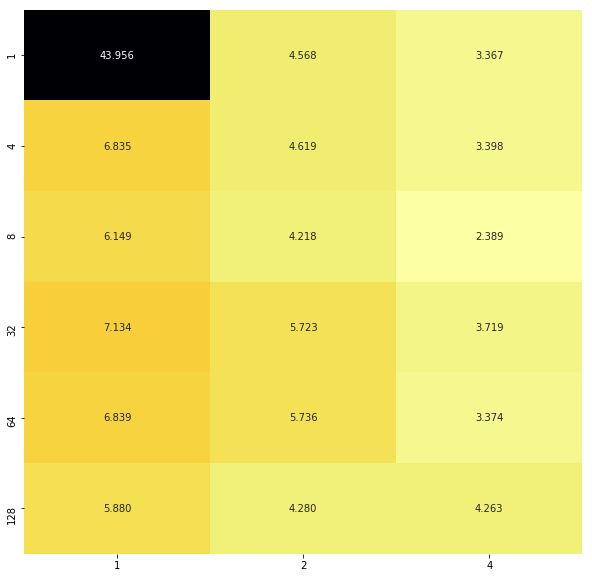

In [27]:
import seaborn as sns

df_times=pd.DataFrame(times_array.T,partitions,workers)

fig,ax=plt.subplots(figsize=[10,10])

sns.heatmap(df_times,cmap='inferno_r',square=False,annot=True,fmt='.3f',cbar=False,ax=ax)
plt.title('Computing time as a function of number of workers and partitions', fontweight='bold')
plt.ylabel('workers')
plt.xlabel('partitions')
plt.show()

## 1.3.2) Which are the worst and best represented countries in the research?


In this paragraph the geographical location of the authors of the papers is explored. In the first part we analyzed the affiliation countries while in the second one we focused on the institutions. For both cases we zoomed on the best and the worst entities.

As in the previous case, an analysis of the performances has been performed by re-running the code multiple times with a different number of partitions and workers.

In [ ]:
cluster = LocalCluster(n_workers=4,threads_per_worker=2) 
client  = Client(cluster)
#client = Client('localhost:8786')
client

Client Scheduler: tcp://127.0.0.1:60073 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.43 GB


In [5]:
def country_getter(paper_dict):
    
    authors = paper_dict['metadata']['authors']
    countries = {}
    for author in authors:
        try:
            
            country = author['affiliation']['location']['country']

                
        except:
            country = 'Not Available'
            
        if country not in countries.keys():
            country = country.replace(' Correspondence', '').replace(' Correspondencia', '').replace(';','').replace(':','')
            country = country.replace('. •', '').replace('.','').replace(' ²Our Research','').replace(' A B S T R A C T', '')
            c_list = country.split(', ')
            for c in c_list:
                if c not in countries.keys():
                    countries[c] = 1
                else:
                    countries[c] +=1
        else:
            countries[country]+=1
    
    return countries



def country_getter2(author):
    
    author2 = author
    
    try:
        
        country = author['affiliation']['location']['country']

                
    except:
        
        country = 'Not Available'
            

    country = country.replace(' Correspondence', '').replace(' Correspondencia', '').replace(';','').replace(':','')
    country = country.replace('. •', '').replace('.','').replace(' ²Our Research','').replace(' A B S T R A C T', '')
    country = country.split(', ')[0]

    author2['country'] = country
    try :
        institution = author['affiliation']['institution']
    except:
        institution = 'Not Available'
        
    author2['institution'] = institution

    return author2

To try a different approach, the function now does not use a foldby.

In [ ]:
authors = b.pluck('metadata').pluck('authors').flatten().map(country_getter2)


authors = authors.to_dataframe()

replacements     = {'PR China':'China',"People's Republic of China":'China','China (':'China','P R China':'China',
                'ROC':'Taiwan',
                'Mexico City':'Mexico',
                'Japan (':'Japan',
                'UK':'United Kingdom', 'UK)':'United Kingdom', 'Public Health England':'United Kingdom',
                'UK A R':'United Kingdom','Scotland':'United Kingdom',
                'Spain Address':'Spain', 'España':'Spain', 'Spain email':'Spain', 'Spain 11':'Spain',
                '4 Switzerland':'Switzerland',
                'U.S.A':'USA', 'United States of America':'USA', 'United States':'USA', 'The United States of America':'USA',
                'UT':'USA', 'Ann Arbor':'USA', 'Unites States of America':'USA',
                'Brasil':'Brazil', 'Brazil R':'Brazil', 'Brazil (':'Brazil',
                'Österreich':'Austria', 'Austria *Correspondence':'Austria',
                'Italien':'Italy', 'Italia':'Italy',
                'Iran (the Islamic Republic of':'Iran',
                'Osmaniye':'Turkey', 'Gokhan':'Turkey',
                'the Netherlands':'Netherlands', 'The Netherlands':'Netherlands',
                'Korea':'South Korea', 'Republic of Korea':'South Korea',
                'SA Avenida Italia':'Uruguay',
                'Canada ²Our Research':'Canada',
                'Valledupar Colombia':'Colombia',
                'New Caledonia':'France',
                'Schweden':'Sweden', 
                'Norwegen':'Norway',
                '7 Germany':'Germany', 'Deutschland':'Germany'
                }
# The computed dataframe is cleaned and the counts are merged. Not available countries
# are removed.
authors     = authors.replace(replacements)


countries_count =  authors['country'].value_counts().compute()

In [ ]:
df_new = pd.DataFrame(countries_count.items(),columns = ['Country','N'],index=countries_count.keys)

In [ ]:
## POST-PROCESSING FUNCTIONS ##

def country_proc(df):
    
    # We want to merge the different country names to a single country
    replacements     = {'PR China':'China',"People's Republic of China":'China','China (':'China','P R China':'China',
                    'ROC':'Taiwan',
                    'Mexico City':'Mexico',
                    'Japan (':'Japan',
                    'UK':'United Kingdom', 'UK)':'United Kingdom', 'Public Health England':'United Kingdom',
                    'UK A R':'United Kingdom','Scotland':'United Kingdom',
                    'Spain Address':'Spain', 'España':'Spain', 'Spain email':'Spain', 'Spain 11':'Spain',
                    '4 Switzerland':'Switzerland',
                    'U.S.A':'USA', 'United States of America':'USA', 'United States':'USA', 'The United States of America':'USA',
                    'UT':'USA', 'Ann Arbor':'USA', 'Unites States of America':'USA',
                    'Brasil':'Brazil', 'Brazil R':'Brazil', 'Brazil (':'Brazil',
                    'Österreich':'Austria', 'Austria *Correspondence':'Austria',
                    'Italien':'Italy', 'Italia':'Italy',
                    'Iran (the Islamic Republic of':'Iran',
                    'Osmaniye':'Turkey', 'Gokhan':'Turkey',
                    'the Netherlands':'Netherlands', 'The Netherlands':'Netherlands',
                    'Korea':'South Korea', 'Republic of Korea':'South Korea',
                    'SA Avenida Italia':'Uruguay',
                    'Canada ²Our Research':'Canada',
                    'Valledupar Colombia':'Colombia',
                    'New Caledonia':'France',
                    'Schweden':'Sweden', 
                    'Norwegen':'Norway',
                    '7 Germany':'Germany', 'Deutschland':'Germany'
                    }
    # The computed dataframe is cleaned and the counts are merged. Not available countries
    # are removed.
    df     = df.replace(replacements)
    df_new = df.groupby(by='Country',axis=0).sum().sort_values(by='N', ascending=False)
    df_new = df_new.loc[df_new.index != 'Not Available']
    n_to_plot = 20

    #First plot: most represented countries in research
    list_of_vals = df_new.values.flatten()[0:n_to_plot]
    list_of_keys = list(df_new.index)[0:n_to_plot]

    plt.figure(figsize=(12,7))
    plt.barh(list_of_keys[::-1], list_of_vals[::-1])
    plt.title('Most represented countries in research', fontweight='bold')
    plt.xlabel('Counts')

    plt.show()
    
    # Second plot: least represented countries in research
    a = df_new[df_new['N']==1]

    list_of_vals = a.values.flatten()
    list_of_keys = list(a.index)

    plt.figure(figsize=(12,7))
    plt.barh(list_of_keys, list_of_vals)
    plt.title('Least represented countries in research', fontweight='bold')
    plt.xlabel('Counts')

    plt.show()
    return df_new



def country_plot(df_new):
    
    # We want to merge the different country names to a single country
    
    n_to_plot = 20

    #First plot: most represented countries in research
    list_of_vals = df_new['N'][:n_to_plot]
    list_of_keys = list(df_new.index)[0:n_to_plot]

    plt.figure(figsize=(12,7))
    plt.barh(list_of_keys[::-1], list_of_vals[::-1])
    plt.title('Most represented countries in research', fontweight='bold')
    plt.xlabel('Counts')

    plt.show()
    
    # Second plot: least represented countries in research
    a = df_new[df_new['N']==1]

    list_of_vals = a['N']
    list_of_keys = list(a.index)

    plt.figure(figsize=(12,7))
    plt.barh(list_of_keys, list_of_vals)
    plt.title('Least represented countries in research', fontweight='bold')
    plt.xlabel('Counts')

    plt.show()
      
def country_map(df_new):
    
    # A geodataframe is created for world map
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    
    # Some pre-processing of our data
    data_for_map = df_new.rename(index = str, columns = {'Country':'name', 'N':'N'})
    data_for_map['name'] = data_for_map.index
    data_for_map.loc['USA','name'] = 'United States of America'
    data_for_map.loc['Czech Republic', 'name'] = 'Czechia'
    data_for_map
    data_for_map.index = data_for_map['name']
    
    # geodataframe and dataset are merged
    merged = world.set_index('name').join(data_for_map.set_index('name'))
    
    # plot
    vmin, vmax = 0.1, 720
    fig, ax = plt.subplots(1, figsize=(15,15))
    ax.set_title('Most and least represented countries', fontweight = 'bold')


    merged.plot(ax=ax, column='N', cmap='PuBu',  norm=colors.LogNorm(vmin=vmin, vmax=vmax))

    sm = plt.cm.ScalarMappable(cmap='PuBu', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    sm._A = []

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(sm,fraction=0.046, pad=0.04, cax=cax)

    ax.axis('off')
    

Barplots of best and worst represented countries are shown below, along with a geographical map that embeds our results.

In [ ]:
country_plot(df_new)

In [ ]:
country_map(df_new)

In the above map it is possible to see that the countries with the greatest number of publication are China, where the first cases of COVID-19 were reported, and USA, where there are some of the best medical institutes. It is also possible to see that in many african states there are no publication. This could be due to the fact that in Africa che Covid pandemic was not so harsh.

In [ ]:
partitions = [1,4,8,32,64,128]
workers = [1,2,4]
times_array=np.zeros([len(workers),len(partitions)])

for i in range(len(workers)):
    for j in range(len(partitions)):
        
        cluster = LocalCluster(n_workers= workers[i],threads_per_worker=2)
        client = Client(cluster)
        
        b = db.read_text(flist).map(json.loads).repartition(partitions[j])
        time1 = time.time()
        
        country_count = b.map(country_getter).fold(reduce_counts).compute()
        
        times_array[i,j] = time.time() - time1
        
        client.close()
        cluster.close()
        

C:\Users\luca3\Anaconda3\lib\site-packages\distributed\dashboard\core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [WinError 10048] Di norma è consentito un solo utilizzo di ogni indirizzo di socket (protocollo/indirizzo di rete/porta)
  warnings.warn("\n" + msg)


Thanks to this heatmap it's possible to quikly find out that, in this case, the fastest cluster is the one with ??????????????????? workers and ????????????????? partitions.

### Institutions represented in research

In [ ]:
def institution_getter(paper_dict):
    
    authors = paper_dict['metadata']['authors']
    institutions = {}
    for author in authors:
        try:
            
            inst = author['affiliation']['institution']
            if inst == '':
                inst = 'Not Available'

                
        except:
            inst = 'Not Available'
            
        if inst not in institutions.keys():
            institutions[inst] = 1
        else:
            institutions[inst]+=1
    
    return institutions

def institution_proc2(df_new):


    #df= df.loc[df_new.index != 'Not Available']
    
    n_to_plot = 20

    list_of_vals = df_new['N'][0:n_to_plot]
    list_of_keys = list(df_new.index)[0:n_to_plot]

    plt.figure(figsize=(14,8))
    plt.barh(list_of_keys[::-1], list_of_vals[::-1])
    plt.title('Most represented institutions in research', fontweight='bold')
    plt.xlabel('Counts')

    plt.show()
    
    print('The least represented institutions in research (a single citation) are', len(df_new[df_new['N']==1]), '.')
    

In [ ]:
institutions = authors['institution'].value_counts().compute()
df     = pd.DataFrame(institutions.items(),columns = ['Institution','N'],index=institutions.keys())



In [ ]:
def institution_proc(df):


    df_new = df.groupby(by='Institution',axis=0).sum().sort_values(by='N', ascending=False)
    df_new = df_new.loc[df_new.index != 'Not Available']
    
    n_to_plot = 20

    list_of_vals = df_new.values.flatten()[0:n_to_plot]
    list_of_keys = list(df_new.index)[0:n_to_plot]

    plt.figure(figsize=(14,8))
    plt.barh(list_of_keys[::-1], list_of_vals[::-1])
    plt.title('Most represented institutions in research', fontweight='bold')
    plt.xlabel('Counts')

    plt.show()
    
    print('The least represented institutions in research (a single citation) are', len(df_new[df_new['N']==1]), '.')

In [ ]:
institution_proc(df)

### NLP algorithm

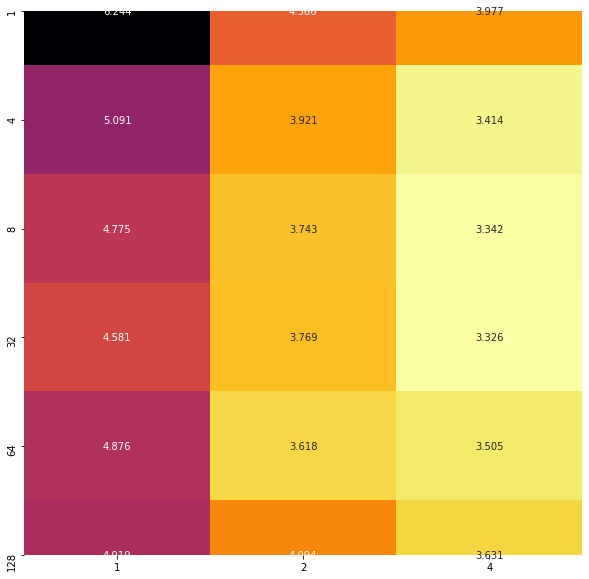

In [ ]:
df_times=pd.DataFrame(times_array.T,partitions,workers)


fig,ax=plt.subplots(figsize=[10,10])


sns.heatmap(df_times,cmap='inferno_r',square=False,annot=True,fmt='.3f',cbar=False,ax=ax)
#plt.ylabel('workers')
#plt.xlabel('partitions')
plt.show()

Thanks to this heatmap it's possible to quikly find out that,in this case, the fastest cluster is the one with ??????????????????? workers and ????????????????? partitions.

## 1.3.3) Get the embedding for the title of the papers


In NLP a common technique to perform analysis over a set of texts is to transform the text to a set of vectors each one representing a word inside a document. At the end of the pre-processing the document will be transformed into a list of vectors or a matrix of $n \times m$ where $n$ is the number of words in the document and $m$ is the size of the vector that represents the word $n$. This technique is called **Embedding**.

In this section, a transformation of the titles of all papers into their embedding version has been performed exploiting a pre-trained model.
The pre-trained model we used is wiki.en.vec developed by Bojanowski et al.(2016) and it is based on the Skip Gram technique. The results are stored in a dictionary in form $key:vector$, where the vectors are each one of dimension 300.

In [87]:
def load_wordlist(fname):
    words = {}
    
    with io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore') as fin:
        n, d = map(int, fin.readline().split())
        # n = number of words
        # d = vector dimension
        
        
        embeddings = np.zeros((n, d), dtype=np.float32)
        
        for i, line in enumerate(fin):
            tokens = line.rstrip().split(' ')
            words[tokens[0]] = i
            embeddings[i, :] = np.array(tokens[1:], dtype=np.float32) 
                
        return words, embeddings

In [6]:
# Here we import the pretrained model
t1 = time.time()
words, embedding = load_wordlist('/root/wiki.en.vec')
print('Time = ', np.round((time.time() - t1)/60), 'm')

NameError: name 'load_wordlist' is not defined

In [46]:
def sanitize_text(text):
    forbidden_chars = ".,()[]:*><;°%/+"
    for forbidden_ch in forbidden_chars :
        text = text.replace(forbidden_ch,"")
    return(text.lower())

def extract_title(b):
    title = b['metadata']['title']
    title = sanitize_text(title)
    #print(title)
    title = title.split()
    return {'paper_id':b['paper_id'], 'title': title}

def get_ind_list(b):
    # words = parole con indicy
    title = b['title']
    ind = []
    for word in title:
        #if word != '' and word in pre_words:            
            #ind.append(words[word])
            #print(word)
        ind.append(words.get(word))
    return {'paper_id':b['paper_id'], 'title': ind}


def get_ind_list2(title):
    # words = parole con indicy
    words = json.load(open('words_finder.json'))
    ind = []
    for word in title:
        #if word != '' and word in pre_words:            
            #ind.append(words[word])
            #print(word)
        ind.append(words.get(word))
    return ind



def get_ind_list3(title):
    words = client.gather(w_future)
    ind = []
    for word in title:
        #if word != '' and word in pre_words:            
            #ind.append(words[word])
            #print(word)
        ind.append(words.get(word))
    return ind    
   
def get_embeddings_list(b):
    
    inds = b['title']
    
    fp = io.open('wiki.en.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')
    
    emb = []
    
    inds = list(filter(None, inds))
    
    if len(inds)==0:
        return []
    #emb = [0]*len(inds)
    m = max(inds)
    #ix = 0
    for i, line in enumerate(fp):
        if i in inds:
            tokens = line.rstrip().split(' ')
            #emb[ix] = np.array(tokens[1:], dtype=np.float16)
            #ix +=1
            emb.append(np.array(tokens[1:], dtype=np.float32))
            
        elif i > m:
            break
    fp.close()
    return {'paper_id':b['paper_id'], 'title_embedding': emb}

def get_embeddings_list2(b):
    
    inds = b['title']
    
    inds = list(filter(None, inds))
    
    if len(inds)==0:
        return {'paper_id':b['paper_id'], 'title_embedding': []}  
    
    emb = [embedding[index] for index in inds]
    
    return {'paper_id':b['paper_id'], 'title_embedding': emb}


In [61]:
#cluster = LocalCluster(n_workers=4,threads_per_worker=2) 
#client  = Client(cluster)
client = Client('tcp://10.67.22.15:8786')
client

Client Scheduler: tcp://10.67.22.15:8786 Dashboard: http://10.67.22.15:12222/status,Cluster Workers: 2 Cores: 2 Memory: 4.05 GB


In [50]:
client.close()

In [8]:
with open('dummy.mapd') as file: # file containing the name of the papers
    flist = ['json1line_COVID_papers/'+i.strip() for i in file] # string containing paths
with open('dummy.mapd') as file: 
    #string containing link to the github repository containing the papers.
    flistgit = ['https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/json1line_COVID_papers/'+i.strip() for i in file]

b = db.read_text(flistgit).map(json.loads).repartition(8) 
b

dask.bag<repartition, npartitions=8>

In [63]:
words =  json.load(open('words_finder.json'))
#embeddings = json.load(open('title_embeddings.json'))

In [64]:
intermediate_results = client.map(extract_title).map(get_ind_list).persist(b)#.map(get_embeddings_list).persist()
#prova[2]

In [65]:
results = intermediate_results.map(get_embeddings_list).compute()

## 1.3.4) Bonus Point
Using the previously generated embedding vectors we will now compute the cosine similarity between each paper. 

We used the results to find out the papers with the most similar titles. If the cosine is equal to 1, it means that the vectors have the same orientation and so they are similar vectors. This mean that also the titles will be similar. On the other hand, if the cosine is equal to 0, it means that the vectors are orthogonal and so they are completly different vectors. This mean that the titles will also be completly different.

In [74]:
from scipy import spatial

def cosine_similarity(a, b):
    
    m1, m2 = set(range(len(a))), set(range(len(a)))
    l = min(len(a), len(b))
    cs = 0
    
    for i in np.arange(l):
        
        emb_t1 = np.copy(a)[[*m1]]
        emb_t2 = np.copy(b)[[*m2]]
        min_dist = 1
        
        for ix1, word1 in enumerate(emb_t1):
            for ix2, word2 in enumerate(emb_t2):
                new_dist = spatial.distance.cosine(word1, word2)
                if new_dist < min_dist:
                    min_dist = new_dist
                    rm = [ix1, ix2]
        
        m1 = m1 - set([rm[0]])
        m2 = m2 - set([rm[1]])
        cs = cs + min_dist
    
    return 1 - cs/l



def cosine_similarity1(a, b):
    
    l = min(len(a), len(b))
    cs = 0
        
    emb_t1 = np.copy(a)
    emb_t2 = np.copy(b)



    for ix1, word1 in enumerate(emb_t1):
        foo = []

        for ix2, word2 in enumerate(emb_t2):

            new_dist = 1 - spatial.distance.cosine(word1, word2)
            
            foo.append(new_dist)
        
        foo = max(foo)
        cs = cs + foo
    
    return cs/len(emb_t1)

def cosine_similarity2(a, b):
    

    emb_t1 = np.mean(a,axis=0) 
    emb_t2 = np.mean(b,axis=0) 





    new_dist = spatial.distance.cosine(emb_t1, emb_t2)

    return 1 - new_dist


In [75]:
similarities = np.zeros([10,10])
for i in range(10):
    for j in range(10):
        try:
            similarities[i,j] = cosine_similarity(results[i]['title_embedding'],results[j]['title_embedding'])
        except:
            pass

In [ ]:
results[:10]

In [ ]:
title_embeddings_2 = []

for title in title_embeddings:
    
    try:
        title_embeddings_2.append({'paper_id':title['paper_id'],'title_embedding': [a.tolist() for a in title['title_embedding']]})
    except:
        pass

In [ ]:
for title in title_embeddings[:10]:
    print(title)

In [ ]:
with open('title_embeddings.json','w') as f:

    json.dump(title_embeddings_2,f)

In [ ]:
title_embeddings_2[1]

{'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
 'title_embedding': [[-0.12278000265359879,
   -0.036747999489307404,
   0.2072799950838089,
   -0.01827700063586235,
   -0.0016347999917343259,
   0.02373499982059002,
   -0.03711999952793121,
   -0.286080002784729,
   -0.19088000059127808,
   -0.06868799775838852,
   0.06175500154495239,
   -0.05241600051522255,
   0.16866999864578247,
   -0.11079999804496765,
   -0.11308000236749649,
   -0.2739199995994568,
   -0.30827000737190247,
   0.1820400059223175,
   0.09659399837255478,
   0.29725000262260437,
   -0.0507269985973835,
   0.023406000807881355,
   -0.33812999725341797,
   -0.10599000006914139,
   -0.11248999834060669,
   0.06672199815511703,
   0.14842000603675842,
   -0.31099000573158264,
   -0.09371999651193619,
   0.002770500024780631,
   -0.16806000471115112,
   0.20954999327659607,
   -0.23590999841690063,
   0.07078500092029572,
   -0.2539899945259094,
   -0.11209999769926071,
   -0.1258399933576584,
   -0.113480001

In [ ]:
len(title_embeddings_2)

1058

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2b33b939-6077-4cfb-95d6-a9ab8510ea0b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>